## Transfer learning tuning and saving best models:

### VGG16:
 * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 as base model and freeze at bottleneck layer (stop right before flatten layer). 
  * top_model: tune dense layers (parameters are inspired by the blog source):
     * batch_size 16 seems to work best for small data set 
  * freezed the first 15 layers and fined tuned the last 5 layers (block5 and fully connected layer).
  * extra blog source for callbacks and saving models:
    * [call_backs for best weights](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)
    * [saving models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

### ResNet50:
  * Use Resnet50 to help further improve accuracy:
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
      * [resnet50 blog](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL). 
  * top_model: tune dense layers (parameters are inspired by a few sources):
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)
  * unfreezed the last 5 layers (after activation48 and fully connected layer).
  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
# disable tensorflow logging
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True 
# to log device placement (on which device the operation ran)
# (nothing gets printed in Jupyter, only if you run it standalone)
config.log_device_placement = False
# set this TensorFlow session as the default session for Keras                                    
sess = tf.Session(config=config)
set_session(sess) 
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.


---
#### Import necessary libraries:

In [2]:
import sys
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
%matplotlib inline

#### Load in python files with helper functions and BaseClassifier

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess
import model_tuning_evaluation as mte

%aimport vgg16_preprocess
%aimport model_tuning_evaluation

----
#### Train VGG16 models, save the best weights and show results
* set file_paths and preprocess functions for hat, beard, and eyewear:

In [6]:
FILE_PATH1_HAT_V = '../tuning_data/VGG_16_tuning/bottleneck_train_hat.npy'
FILE_PATH2_HAT_V = '../tuning_data/VGG_16_tuning/bottleneck_test_hat.npy'
FILE_PATH3_HAT_V = '../tuning_data/VGG_16_tuning/top_model_weights_hat.h5'
FILE_PATH4_HAT_V = '../tuning_data/VGG_16_tuning/best_vgg16_model_hattest.h5'
FILE_PATH1_BEARD_V = '../tuning_data/VGG_16_tuning/bottleneck_train_beard.npy'
FILE_PATH2_BEARD_V = '../tuning_data/VGG_16_tuning/bottleneck_test_beard.npy'
FILE_PATH3_BEARD_V = '../tuning_data/VGG_16_tuning/top_model_weights_beard.h5'
FILE_PATH4_BEARD_V = '../tuning_data/VGG_16_tuning/best_vgg16_model_beardtest.h5'
FILE_PATH1_EYEWEAR_V = '../tuning_data/VGG_16_tuning/bottleneck_train_eyewear.npy'
FILE_PATH2_EYEWEAR_V = '../tuning_data/VGG_16_tuning/bottleneck_test_eyewear.npy'
FILE_PATH3_EYEWEAR_V = '../tuning_data/VGG_16_tuning/top_model_weights_eyewear.h5'
FILE_PATH4_EYEWEAR_V = '../tuning_data/VGG_16_tuning/best_vgg16_model_eyeweartest.h5'
RESCALE_V = 1./255
PROCESS_FUNC_V = vgg16_preprocess.preprocess_input
DIM_V = 150
VGG16_MODEL_PATH = '../tuning_data/VGG_16_tuning/vgg_modeltest.json'

#### VGG16_HAT

Found 522 validated image filenames.
Found 131 validated image filenames.
Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Model already exists


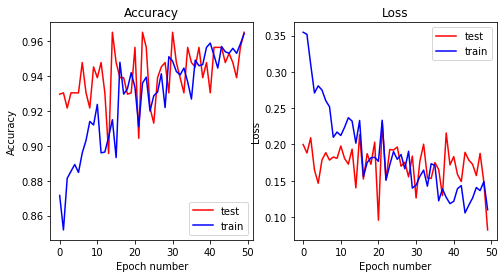

In [10]:
# intialize classifier and tune hat Classifier 
hat_vgg16 = mte.BaseClassifier('hat',RESCALE_V,PROCESS_FUNC_V,DIM_V,VGG16,'vgg16')
hat_vgg16.save_bottleneck_features(FILE_PATH1_HAT_V,FILE_PATH2_HAT_V)
hat_vgg16.train_top_model(50,FILE_PATH3_HAT_V,verbose=0)
hat_vgg16.fine_tune_model(50,FILE_PATH4_HAT_V)
# save model architecture just once
hat_vgg16.save_model(VGG16_MODEL_PATH)
hat_vgg16.plot_model_history()

In [ ]:
# hat_vgg16.file4 = '../tuning_data/VGG_16_tuning/best_vgg16_model_hat.h5'

Found 653 validated image filenames belonging to 2 classes.


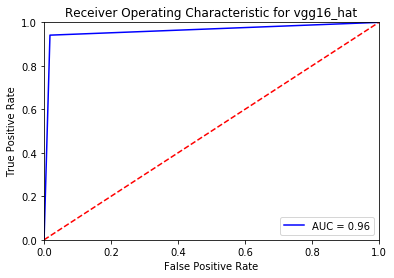

        Pred_0  Pred_1
True_0     391       7
True_1      15     240
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       398
           1       0.97      0.94      0.96       255

    accuracy                           0.97       653
   macro avg       0.97      0.96      0.96       653
weighted avg       0.97      0.97      0.97       653



In [11]:
hat_vgg16.model_testing()

#### VGG16_BEARD

In [ ]:
# intialize classifier and tune beard Classifier 
beard_vgg16 = mte.BaseClassifier('beard',RESCALE_V,PROCESS_FUNC_V,DIM_V,VGG16,'vgg16')
beard_vgg16.save_bottleneck_features(FILE_PATH1_BEARD_V,FILE_PATH2_BEARD_V)
beard_vgg16.train_top_model(50,FILE_PATH3_BEARD_V,verbose=0)
beard_vgg16.fine_tune_model(50,FILE_PATH4_BEARD_V)
beard_vgg16.plot_model_history()

In [ ]:
# beard_vgg16.file4 = '../tuning_data/VGG_16_tuning/best_vgg16_model_beard.h5'

In [ ]:
beard_vgg16.model_testing()

#### VGG16_EYEWEAR

In [ ]:
# intialize classifier and tune eyewear Classifier 
eyewear_vgg16 = mte.BaseClassifier('EYEWEAR',RESCALE_V,PROCESS_FUNC_V,DIM_V,VGG16,'vgg16')
eyewear_vgg16.save_bottleneck_features(FILE_PATH1_EYEWEAR_V,FILE_PATH2_EYEWEAR_V)
eyewear_vgg16.train_top_model(50,FILE_PATH3_EYEWEAR_V,verbose=0)
eyewear_vgg16.fine_tune_model(50,FILE_PATH4_EYEWEAR_V)
eyewear_vgg16.plot_model_history()

In [ ]:
# eyewear_vgg16.file4 = '../tuning_data/VGG_16_tuning/best_vgg16_model_eyeweartest.h5'

In [ ]:
eyewear_vgg16.model_testing()

----
#### Train resnet50 models, save the best weights and show results:
* set file_paths for hat, beard, and eyewear:

In [14]:
FILE_PATH1_HAT_R = '../tuning_data/resnet_data/bottleneck_train_hat.npy'
FILE_PATH2_HAT_R = '../tuning_data/resnet_data/bottleneck_test_hat.npy'
FILE_PATH3_HAT_R = '../tuning_data/resnet_data/top_model_weights_hat.h5'
FILE_PATH4_HAT_R = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hattest.h5'
FILE_PATH1_BEARD_R = '../tuning_data/resnet_data/bottleneck_train_beard.npy'
FILE_PATH2_BEARD_R = '../tuning_data/resnet_data/bottleneck_test_beard.npy'
FILE_PATH3_BEARD_R = '../tuning_data/resnet_data/top_model_weights_beard.h5'
FILE_PATH4_BEARD_R = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beardtest.h5'
FILE_PATH1_EYEWEAR_R = '../tuning_data/resnet_data/bottleneck_train_eyewear.npy'
FILE_PATH2_EYEWEAR_R = '../tuning_data/resnet_data/bottleneck_test_eyewear.npy'
FILE_PATH3_EYEWEAR_R = '../tuning_data/resnet_data/top_model_weights_eyewear.h5'
FILE_PATH4_EYEWEAR_R = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyeweartest.h5'
RESNET_MODEL_PATH = '../tuning_data/resnet_data/resnet50_model_5_uptest.json'
RESCALE_R = None
PROCESS_FUNC_R = preprocess_input
DIM_R = 224

#### ResNet50_HAT

In [ ]:
# intialize classifier and tune hat Classifier 
hat_resnet50 = mte.BaseClassifier('hat',RESCALE_R,PROCESS_FUNC_R,DIM_R,ResNet50,'resnet50')
hat_resnet50.save_bottleneck_features(FILE_PATH1_HAT_R,FILE_PATH2_HAT_R)
hat_resnet50.train_top_model(50,FILE_PATH3_HAT_R,verbose=0)
hat_resnet50.fine_tune_model(50,FILE_PATH4_HAT_R)
# save model architecture just once
hat_resnet50.save_model(RESNET_MODEL_PATH)
hat_resnet50.plot_model_history()

Found 522 validated image filenames.
Found 131 validated image filenames.
Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


In [ ]:
# hat_resnet50.path4 = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hat.h5'

In [ ]:
hat_resnet50.model_testing()

#### ResNet50_BEARD

In [ ]:
# intialize classifier and tune beard Classifier 
beard_resnet50 = mte.BaseClassifier('beard',RESCALE_R,PROCESS_FUNC_R,DIM_R,ResNet50,'resnet50')
beard_resnet50.save_bottleneck_features(FILE_PATH1_BEARD_R,FILE_PATH2_BEARD_R)
beard_resnet50.train_top_model(50,FILE_PATH3_BEARD_R,verbose=0)
beard_resnet50.fine_tune_model(50,FILE_PATH4_BEARD_R)
# save model architecture just once
beard_resnet50.save_model(RESNET_MODEL_PATH)
beard_resnet50.plot_model_history()()

In [ ]:
# beard_resnet50.path4 = ../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beard.h5'

In [ ]:
beard_resnet50.model_testing()

#### ResNet50_EYEWEAR

In [ ]:
# intialize classifier and tune eyewear Classifier 
eyewear_resnet50 = mte.BaseClassifier('eyewear',RESCALE_R,PROCESS_FUNC_R,DIM_R,ResNet50,'resnet50')
eyewear_resnet50.save_bottleneck_features(FILE_PATH1_EYEWEAR_R,FILE_PATH2_EYEWEAR_R)
eyewear_resnet50.train_top_model(50,FILE_PATH3_EYEWEAR_R,verbose=0)
eyewear_resnet50.fine_tune_model(50,FILE_PATH4_EYEWEAR_R)
# save model architecture just once
eyewear_resnet50.save_model(RESNET_MODEL_PATH)
eyewear_resnet50.plot_model_history()()

In [ ]:
# eyewear_resnet50.path4= '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyeweartest.h5'

In [ ]:
eyewear_resnet50.model_testing()